In [8]:
import pandas as pd
import scanpy as sc
from flask import Flask, jsonify, request
from scipy.io import mmread
from scipy import sparse
import seaborn as sns
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import h5py
import csv
import os
import loompy
import anndata
from pandas import HDFStore
from sklearn.manifold import TSNE
import collections
import scipy.sparse as sp_sparse
import tables
import plotly.express as px
from sklearn.preprocessing import StandardScaler

## Data Loading


In [9]:
genes = pd.read_csv("../Data/Genes.csv")
barcode_positions = pd.read_csv("../Data/SpotPositions.csv")
tSNE_df = pd.read_csv("../Data/t-SNE_Projection.csv")
tSNE_graphed_df = pd.read_csv("../Data/t-SNE_Graph_Based.csv")
barcode_clusterMembership = pd.read_csv("../Data/SpotClusterMembership.csv")

In [10]:
up_regulated_L2FC_genes = pd.read_csv("../Data/up_regulated_L2FC_genes.csv")

In [11]:
adata = sc.read_10x_h5("../Data/Filtered_feature_bc_matrix.h5")

/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Data Display


In [12]:
genes

,gene,feature_type
0,Xkr4,Gene Expression
1,Gm1992,Gene Expression
2,Gm37381,Gene Expression
3,Rp1,Gene Expression
4,Sox17,Gene Expression
...,...,...
31048,AC168977.1,Gene Expression
31049,AC149090.1,Gene Expression
31050,CAAA01118383.1,Gene Expression
31051,Vmn2r122,Gene Expression


In [13]:
barcode_positions

,barcode,x,y,radius
0,AAACAAGTATCTCCCA-1,12709.0,10806.0,71.192911
1,AAACACCAATAACTGC-1,3616.0,12513.0,71.192911
2,AAACAGAGCGACTCCT-1,11839.0,3944.0,71.192911
3,AAACAGGGTCTATATT-1,2961.0,10225.0,71.192911
4,AAACATTTCCCGGATT-1,12159.0,12902.0,71.192911
...,...,...,...,...
3494,TTGTTGTGTGTCAAGA-1,9974.0,7183.0,71.192911
3495,TTGTTTCACATCCAGG-1,6136.0,12325.0,71.192911
3496,TTGTTTCATTAGTCTA-1,4821.0,12705.0,71.192911
3497,TTGTTTCCATACAACT-1,4495.0,9846.0,71.192911


In [14]:
tSNE_df

,Barcode,X Coordinate,Y Coordinate
0,AAACAAGTATCTCCCA-1,7.170149,-6.169523
1,AAACACCAATAACTGC-1,-24.983043,-8.407789
2,AAACAGAGCGACTCCT-1,-12.087320,36.968580
3,AAACAGGGTCTATATT-1,-21.366652,-5.311882
4,AAACATTTCCCGGATT-1,11.085326,-17.753664
...,...,...,...
3494,TTGTTGTGTGTCAAGA-1,35.546637,-23.506554
3495,TTGTTTCACATCCAGG-1,-3.515596,15.672737
3496,TTGTTTCATTAGTCTA-1,-20.753882,-5.643660
3497,TTGTTTCCATACAACT-1,-9.796795,22.895259


In [15]:
tSNE_graphed_df

,Barcode,Graph-based
0,AAACAAGTATCTCCCA-1,Cluster 2
1,AAACACCAATAACTGC-1,Cluster 4
2,AAACAGAGCGACTCCT-1,Cluster 6
3,AAACAGGGTCTATATT-1,Cluster 5
4,AAACATTTCCCGGATT-1,Cluster 2
...,...,...
3494,TTGTTGTGTGTCAAGA-1,Cluster 5
3495,TTGTTTCACATCCAGG-1,Cluster 1
3496,TTGTTTCATTAGTCTA-1,Cluster 3
3497,TTGTTTCCATACAACT-1,Cluster 7


In [16]:
up_regulated_L2FC_genes

,FeatureID,FeatureName,Cluster 1 Average,Cluster 1 Log2 Fold Change,Cluster 1 P-Value,Cluster 2 Average,Cluster 2 Log2 Fold Change,Cluster 2 P-Value,Cluster 3 Average,Cluster 3 Log2 Fold Change,...,Cluster 6 P-Value,Cluster 7 Average,Cluster 7 Log2 Fold Change,Cluster 7 P-Value,Cluster 8 Average,Cluster 8 Log2 Fold Change,Cluster 8 P-Value,Cluster 9 Average,Cluster 9 Log2 Fold Change,Cluster 9 P-Value
0,ENSMUSG00000026344,Lypd1,5.274823,2.993237,8.343679e-50,0.574604,-1.795078,0.000128,1.003316,-0.926066,...,0.000359,0.559763,-1.886218,9.328407e-07,1.135633,-0.756241,4.129231e-01,0.727973,-1.368460,1.0
1,ENSMUSG00000045573,Penk,5.499242,2.478801,1.178593e-28,1.204652,-0.907644,0.218760,1.003316,-1.147330,...,1.000000,0.644255,-1.899512,1.020071e-05,0.834278,-1.441520,3.524474e-02,1.361403,-0.679557,1.0
2,ENSMUSG00000071379,Hpcal1,3.581923,2.091830,1.407899e-26,1.875024,0.308009,0.703854,0.833867,-0.931656,...,0.001595,0.918856,-0.848315,7.454362e-02,0.682014,-1.249573,2.749374e-02,0.444347,-1.812791,1.0
3,ENSMUSG00000040565,Btaf1,1.689973,1.720945,5.081825e-17,0.315024,-1.462562,0.001502,0.931969,0.202525,...,0.197208,0.670659,-0.326263,9.336061e-01,0.434586,-0.962119,1.504582e-01,0.614522,-0.412310,1.0
4,ENSMUSG00000068696,Gpr88,1.309436,1.809333,1.637077e-16,0.136090,-2.274629,0.000003,0.459296,-0.436956,...,0.576842,0.237635,-1.506374,3.138400e-04,0.066615,-3.252758,4.845342e-08,0.283626,-1.105550,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,ENSMUSG00000024991,Eif3a,0.912312,0.067565,1.000000e+00,1.063521,0.304276,0.719242,0.833867,-0.083417,...,1.000000,0.853727,-0.053208,1.000000e+00,0.812072,-0.126963,1.000000e+00,0.756335,-0.222079,1.0
1405,ENSMUSG00000064341,mt-Nd1,111.716779,0.077072,1.000000e+00,105.510399,-0.031026,1.000000,168.717580,0.696516,...,0.302693,92.517551,-0.249757,1.000000e+00,62.152093,-0.844279,1.567308e-01,152.203004,0.507060,1.0
1406,ENSMUSG00000064351,mt-Co1,346.376167,0.063527,1.000000e+00,287.652304,-0.246331,0.915168,598.850198,0.901104,...,0.119922,301.317933,-0.179860,1.000000e+00,186.776668,-0.901889,1.160769e-01,476.566806,0.511451,1.0
1407,ENSMUSG00000064356,mt-Atp8,2.994531,0.037391,1.000000e+00,2.527754,-0.240526,0.932790,7.629659,1.517481,...,0.385615,1.999656,-0.630584,2.607485e-01,1.291068,-1.254722,2.230199e-02,5.237621,0.855277,1.0


In [18]:
# TTGGATATCGTCTACG-1 and TGCGCCGTTAATAACG-1 index
missing_cell_index1 = barcode_positions.index[
    barcode_positions["barcode"] == "TTGGATATCGTCTACG-1"
].tolist()[0]
missing_cell_index2 = barcode_positions.index[
    barcode_positions["barcode"] == "TGCGCCGTTAATAACG-1"
].tolist()[0]
print(missing_cell_index1, missing_cell_index2)

3463 3154


## Data Processing


In [20]:
df_tsne_graphed_position_cluster = pd.merge(tSNE_graphed_df, tSNE_df, on="Barcode")
df_tsne_graphed_position_cluster

,Barcode,Graph-based,X Coordinate,Y Coordinate
0,AAACAAGTATCTCCCA-1,Cluster 2,7.170149,-6.169523
1,AAACACCAATAACTGC-1,Cluster 4,-24.983043,-8.407789
2,AAACAGAGCGACTCCT-1,Cluster 6,-12.087320,36.968580
3,AAACAGGGTCTATATT-1,Cluster 5,-21.366652,-5.311882
4,AAACATTTCCCGGATT-1,Cluster 2,11.085326,-17.753664
...,...,...,...,...
3494,TTGTTGTGTGTCAAGA-1,Cluster 5,35.546637,-23.506554
3495,TTGTTTCACATCCAGG-1,Cluster 1,-3.515596,15.672737
3496,TTGTTTCATTAGTCTA-1,Cluster 3,-20.753882,-5.643660
3497,TTGTTTCCATACAACT-1,Cluster 7,-9.796795,22.895259


In [24]:
tSNE_df.rename(
    columns={"X Coordinate": "x", "Y Coordinate": "y", "Barcode": "barcode"},
    inplace=True,
)
adata.var_names_make_unique()
umi_counts = adata.to_df()
umi_counts

,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,Tcea1,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,Vmn2r122,CAAA01147332.1
AAACAAGTATCTCCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACACCAATAACTGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAGAGCGACTCCT-1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
AAACAGGGTCTATATT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTTCCCGGATT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
TTGTTTCACATCCAGG-1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
TTGTTTCATTAGTCTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTCCATACAACT-1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [25]:
total_counts = umi_counts.sum(axis=1)
cellTotal_df = pd.DataFrame(
    {"barcode": total_counts.index, "total_counts": total_counts.values}
)
cellTotal_df

,barcode,total_counts
0,AAACAAGTATCTCCCA-1,12174.0
1,AAACACCAATAACTGC-1,5637.0
2,AAACAGAGCGACTCCT-1,26316.0
3,AAACAGGGTCTATATT-1,6462.0
4,AAACATTTCCCGGATT-1,7195.0
...,...,...
3494,TTGTTGTGTGTCAAGA-1,6219.0
3495,TTGTTTCACATCCAGG-1,14493.0
3496,TTGTTTCATTAGTCTA-1,6621.0
3497,TTGTTTCCATACAACT-1,18042.0


In [26]:
umi_df = umi_counts
umi_df.reset_index(inplace=True)
umi_df.rename(columns={"index": "barcode"}, inplace=True)
umi_df

,barcode,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,Vmn2r122,CAAA01147332.1
0,AAACAAGTATCTCCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AAACACCAATAACTGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AAACAGAGCGACTCCT-1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
3,AAACAGGGTCTATATT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AAACATTTCCCGGATT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494,TTGTTGTGTGTCAAGA-1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3495,TTGTTTCACATCCAGG-1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3496,TTGTTTCATTAGTCTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3497,TTGTTTCCATACAACT-1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [27]:
tSNE_graphed_df.rename(columns={"Barcode": "barcode"}, inplace=True)
tSNE_graphed_df

,barcode,Graph-based
0,AAACAAGTATCTCCCA-1,Cluster 2
1,AAACACCAATAACTGC-1,Cluster 4
2,AAACAGAGCGACTCCT-1,Cluster 6
3,AAACAGGGTCTATATT-1,Cluster 5
4,AAACATTTCCCGGATT-1,Cluster 2
...,...,...
3494,TTGTTGTGTGTCAAGA-1,Cluster 5
3495,TTGTTTCACATCCAGG-1,Cluster 1
3496,TTGTTTCATTAGTCTA-1,Cluster 3
3497,TTGTTTCCATACAACT-1,Cluster 7


In [28]:
total_cell_df = pd.merge(cellTotal_df, umi_df, on="barcode")
total_cell_df

,barcode,total_counts,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,Mrpl15,Lypla1,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,Vmn2r122,CAAA01147332.1
0,AAACAAGTATCTCCCA-1,12174.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AAACACCAATAACTGC-1,5637.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AAACAGAGCGACTCCT-1,26316.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
3,AAACAGGGTCTATATT-1,6462.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AAACATTTCCCGGATT-1,7195.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494,TTGTTGTGTGTCAAGA-1,6219.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3495,TTGTTTCACATCCAGG-1,14493.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3496,TTGTTTCATTAGTCTA-1,6621.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3497,TTGTTTCCATACAACT-1,18042.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [29]:
# log2 transformation
umi_df.loc[:, umi_df.columns != "barcode"] = np.log2(
    umi_df.loc[:, umi_df.columns != "barcode"] + 1
)
umi_df

,barcode,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,Vmn2r122,CAAA01147332.1
0,AAACAAGTATCTCCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,1.584962,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,AAACACCAATAACTGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,AAACAGAGCGACTCCT-1,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.584962,0.0,0.0,0.0
3,AAACAGGGTCTATATT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,AAACATTTCCCGGATT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494,TTGTTGTGTGTCAAGA-1,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
3495,TTGTTTCACATCCAGG-1,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
3496,TTGTTTCATTAGTCTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3497,TTGTTTCCATACAACT-1,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0


In [30]:
# logNormalize
total_cell_df.loc[:, total_cell_df.columns != "barcode"] = (
    total_cell_df.loc[:, total_cell_df.columns != "barcode"].div(
        total_cell_df["total_counts"], axis=0
    )
    * 10000
)

total_cell_df.loc[:, total_cell_df.columns != "barcode"] = np.log1p(
    total_cell_df.loc[:, total_cell_df.columns != "barcode"]
)
total_cell_df

,barcode,total_counts,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,Mrpl15,Lypla1,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,Vmn2r122,CAAA01147332.1
0,AAACAAGTATCTCCCA-1,9.210441,0.000000,0.0,0.0,0.0,0.0,0.0,0.971856,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,AAACACCAATAACTGC-1,9.210441,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,AAACAGAGCGACTCCT-1,9.210441,0.000000,0.0,0.0,0.0,0.0,0.0,0.322081,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.565310,0.0,0.0,0.0
3,AAACAGGGTCTATATT-1,9.210441,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,AAACATTTCCCGGATT-1,9.210441,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494,TTGTTGTGTGTCAAGA-1,9.210441,0.000000,0.0,0.0,0.0,0.0,0.0,0.958574,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.958574,0.0,0.0,0.0
3495,TTGTTTCACATCCAGG-1,9.210441,0.524722,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.524722,0.0,0.0,0.0
3496,TTGTTTCATTAGTCTA-1,9.210441,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3497,TTGTTTCCATACAACT-1,9.210441,0.000000,0.0,0.0,0.0,0.0,0.0,0.979373,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.441001,0.0,0.0,0.0


In [31]:
violin_logNorm_df = pd.merge(total_cell_df, tSNE_graphed_df, on="barcode")
violin_logNorm_df

,barcode,total_counts,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,Mrpl15,Lypla1,...,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,Vmn2r122,CAAA01147332.1,Graph-based
0,AAACAAGTATCTCCCA-1,9.210441,0.000000,0.0,0.0,0.0,0.0,0.0,0.971856,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,Cluster 2
1,AAACACCAATAACTGC-1,9.210441,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,Cluster 4
2,AAACAGAGCGACTCCT-1,9.210441,0.000000,0.0,0.0,0.0,0.0,0.0,0.322081,0.0,...,0.0,0.0,0.0,0.0,0.0,0.565310,0.0,0.0,0.0,Cluster 6
3,AAACAGGGTCTATATT-1,9.210441,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,Cluster 5
4,AAACATTTCCCGGATT-1,9.210441,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,Cluster 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494,TTGTTGTGTGTCAAGA-1,9.210441,0.000000,0.0,0.0,0.0,0.0,0.0,0.958574,0.0,...,0.0,0.0,0.0,0.0,0.0,0.958574,0.0,0.0,0.0,Cluster 5
3495,TTGTTTCACATCCAGG-1,9.210441,0.524722,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.524722,0.0,0.0,0.0,Cluster 1
3496,TTGTTTCATTAGTCTA-1,9.210441,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,Cluster 3
3497,TTGTTTCCATACAACT-1,9.210441,0.000000,0.0,0.0,0.0,0.0,0.0,0.979373,0.0,...,0.0,0.0,0.0,0.0,0.0,0.441001,0.0,0.0,0.0,Cluster 7


In [32]:
violin_df = pd.merge(tSNE_graphed_df, umi_df, on="barcode")
violin_df

,barcode,Graph-based,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,Mrpl15,Lypla1,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,Vmn2r122,CAAA01147332.1
0,AAACAAGTATCTCCCA-1,Cluster 2,0.0,0.0,0.0,0.0,0.0,0.0,1.584962,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,AAACACCAATAACTGC-1,Cluster 4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,AAACAGAGCGACTCCT-1,Cluster 6,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.584962,0.0,0.0,0.0
3,AAACAGGGTCTATATT-1,Cluster 5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,AAACATTTCCCGGATT-1,Cluster 2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494,TTGTTGTGTGTCAAGA-1,Cluster 5,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
3495,TTGTTTCACATCCAGG-1,Cluster 1,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
3496,TTGTTTCATTAGTCTA-1,Cluster 3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3497,TTGTTTCCATACAACT-1,Cluster 7,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0


In [33]:
violin_barcode_index_df = violin_df
result_dict = violin_df.set_index("barcode")["Xkr4"].to_dict()
result_dict

{'AAACAAGTATCTCCCA-1': 0.0,
 'AAACACCAATAACTGC-1': 0.0,
 'AAACAGAGCGACTCCT-1': 0.0,
 'AAACAGGGTCTATATT-1': 0.0,
 'AAACATTTCCCGGATT-1': 0.0,
 'AAACCCGAACGAAATC-1': 0.0,
 'AAACCGGAAATGTTAA-1': 0.0,
 'AAACCGGGTAGGTACC-1': 1.0,
 'AAACCGTTCGTCCAGG-1': 0.0,
 'AAACCTCATGAAGTTG-1': 1.0,
 'AAACGAAGAACATACC-1': 1.0,
 'AAACGAGACGGTTGAT-1': 0.0,
 'AAACGCTGGGCACGAC-1': 0.0,
 'AAACGGGCGTACGGGT-1': 0.0,
 'AAACGGTTGCGAACTG-1': 0.0,
 'AAACGTGTTCGCCCTA-1': 0.0,
 'AAACTAACGTGGCGAC-1': 0.0,
 'AAACTCGGTTCGCAAT-1': 0.0,
 'AAACTCGTGATATAAG-1': 0.0,
 'AAACTGCTGGCTCCAA-1': 1.0,
 'AAACTTGCAAACGTAT-1': 0.0,
 'AAAGAATGTGGACTAA-1': 0.0,
 'AAAGACCCAAGTCGCG-1': 0.0,
 'AAAGACTGGGCGCTTT-1': 0.0,
 'AAAGCTTGCCTACATA-1': 1.0,
 'AAAGGCTACGGACCAT-1': 1.0,
 'AAAGGCTCTCGCGCCG-1': 1.0,
 'AAAGGGATGTAGCAAG-1': 0.0,
 'AAAGGGCAGCTTGAAT-1': 0.0,
 'AAAGGTAAGCTGTACC-1': 1.0,
 'AAAGTAGCATTGCTCA-1': 0.0,
 'AAAGTCACTGATGTAA-1': 0.0,
 'AAAGTCGACCCTCAGT-1': 0.0,
 'AAAGTGCCATCAATTA-1': 0.0,
 'AAAGTGTGATTTATCT-1': 1.0,
 'AAAGTTGACTCCCGTA-1

In [34]:
log2_total_df = violin_df
log2_total_df.drop("Graph-based", axis=1, inplace=True)

In [35]:
log2_total_df["log2UMITotal"] = log2_total_df.drop(columns=["barcode"]).sum(axis=1)
log2_total_df

,barcode,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,...,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,Vmn2r122,CAAA01147332.1,log2UMITotal
0,AAACAAGTATCTCCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,1.584962,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,6903.585449
1,AAACACCAATAACTGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2867.757812
2,AAACAGAGCGACTCCT-1,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.584962,0.0,0.0,0.0,11372.973633
3,AAACAGGGTCTATATT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,3514.495361
4,AAACATTTCCCGGATT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,4183.248535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494,TTGTTGTGTGTCAAGA-1,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,3943.838379
3495,TTGTTTCACATCCAGG-1,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,7329.042969
3496,TTGTTTCATTAGTCTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,3537.135498
3497,TTGTTTCCATACAACT-1,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,8388.453125


In [36]:
cell_tsne_df = pd.merge(cellTotal_df, tSNE_df, on="barcode")
# cell_tsne_df
cell_tsne_cluster_UMI_df = pd.merge(
    cell_tsne_df, tSNE_graphed_df, on="barcode", how="left"
)
cell_tsne_cluster_UMI_df

,barcode,total_counts,x,y,Graph-based
0,AAACAAGTATCTCCCA-1,12174.0,7.170149,-6.169523,Cluster 2
1,AAACACCAATAACTGC-1,5637.0,-24.983043,-8.407789,Cluster 4
2,AAACAGAGCGACTCCT-1,26316.0,-12.087320,36.968580,Cluster 6
3,AAACAGGGTCTATATT-1,6462.0,-21.366652,-5.311882,Cluster 5
4,AAACATTTCCCGGATT-1,7195.0,11.085326,-17.753664,Cluster 2
...,...,...,...,...,...
3494,TTGTTGTGTGTCAAGA-1,6219.0,35.546637,-23.506554,Cluster 5
3495,TTGTTTCACATCCAGG-1,14493.0,-3.515596,15.672737,Cluster 1
3496,TTGTTTCATTAGTCTA-1,6621.0,-20.753882,-5.643660,Cluster 3
3497,TTGTTTCCATACAACT-1,18042.0,-9.796795,22.895259,Cluster 7


In [41]:
with h5py.File("../Data/Filtered_feature_bc_matrix.h5", "r") as file:
    matrix_group = file["matrix"]

    # Access the 'features' subgroup to get gene names and IDs
    features_group = matrix_group["features"]
    gene_names = [name.decode() for name in features_group["name"][:]]
    gene_ids = [gene_id.decode() for gene_id in features_group["id"][:]]

    # Generate DataFrame
    gene_featureid_name_df = pd.DataFrame(
        {"FeatureID": gene_ids, "Gene Name": gene_names}
    )

gene_featureid_name_df

,FeatureID,Gene Name
0,ENSMUSG00000051951,Xkr4
1,ENSMUSG00000089699,Gm1992
2,ENSMUSG00000102343,Gm37381
3,ENSMUSG00000025900,Rp1
4,ENSMUSG00000025902,Sox17
...,...,...
31048,ENSMUSG00000079808,AC168977.1
31049,ENSMUSG00000095041,AC149090.1
31050,ENSMUSG00000063897,CAAA01118383.1
31051,ENSMUSG00000096730,Vmn2r122


In [43]:
up_regulated_genes_processed_df = pd.merge(
    up_regulated_L2FC_genes, gene_featureid_name_df, on="FeatureID"
)
up_regulated_genes_processed_df

,FeatureID,FeatureName,Cluster 1 Average,Cluster 1 Log2 Fold Change,Cluster 1 P-Value,Cluster 2 Average,Cluster 2 Log2 Fold Change,Cluster 2 P-Value,Cluster 3 Average,Cluster 3 Log2 Fold Change,...,Cluster 7 Average,Cluster 7 Log2 Fold Change,Cluster 7 P-Value,Cluster 8 Average,Cluster 8 Log2 Fold Change,Cluster 8 P-Value,Cluster 9 Average,Cluster 9 Log2 Fold Change,Cluster 9 P-Value,Gene Name
0,ENSMUSG00000026344,Lypd1,5.274823,2.993237,8.343679e-50,0.574604,-1.795078,0.000128,1.003316,-0.926066,...,0.559763,-1.886218,9.328407e-07,1.135633,-0.756241,4.129231e-01,0.727973,-1.368460,1.0,Lypd1
1,ENSMUSG00000045573,Penk,5.499242,2.478801,1.178593e-28,1.204652,-0.907644,0.218760,1.003316,-1.147330,...,0.644255,-1.899512,1.020071e-05,0.834278,-1.441520,3.524474e-02,1.361403,-0.679557,1.0,Penk
2,ENSMUSG00000071379,Hpcal1,3.581923,2.091830,1.407899e-26,1.875024,0.308009,0.703854,0.833867,-0.931656,...,0.918856,-0.848315,7.454362e-02,0.682014,-1.249573,2.749374e-02,0.444347,-1.812791,1.0,Hpcal1
3,ENSMUSG00000040565,Btaf1,1.689973,1.720945,5.081825e-17,0.315024,-1.462562,0.001502,0.931969,0.202525,...,0.670659,-0.326263,9.336061e-01,0.434586,-0.962119,1.504582e-01,0.614522,-0.412310,1.0,Btaf1
4,ENSMUSG00000068696,Gpr88,1.309436,1.809333,1.637077e-16,0.136090,-2.274629,0.000003,0.459296,-0.436956,...,0.237635,-1.506374,3.138400e-04,0.066615,-3.252758,4.845342e-08,0.283626,-1.105550,1.0,Gpr88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,ENSMUSG00000024991,Eif3a,0.912312,0.067565,1.000000e+00,1.063521,0.304276,0.719242,0.833867,-0.083417,...,0.853727,-0.053208,1.000000e+00,0.812072,-0.126963,1.000000e+00,0.756335,-0.222079,1.0,Eif3a
1405,ENSMUSG00000064341,mt-Nd1,111.716779,0.077072,1.000000e+00,105.510399,-0.031026,1.000000,168.717580,0.696516,...,92.517551,-0.249757,1.000000e+00,62.152093,-0.844279,1.567308e-01,152.203004,0.507060,1.0,mt-Nd1
1406,ENSMUSG00000064351,mt-Co1,346.376167,0.063527,1.000000e+00,287.652304,-0.246331,0.915168,598.850198,0.901104,...,301.317933,-0.179860,1.000000e+00,186.776668,-0.901889,1.160769e-01,476.566806,0.511451,1.0,mt-Co1
1407,ENSMUSG00000064356,mt-Atp8,2.994531,0.037391,1.000000e+00,2.527754,-0.240526,0.932790,7.629659,1.517481,...,1.999656,-0.630584,2.607485e-01,1.291068,-1.254722,2.230199e-02,5.237621,0.855277,1.0,mt-Atp8


## Data Visualization


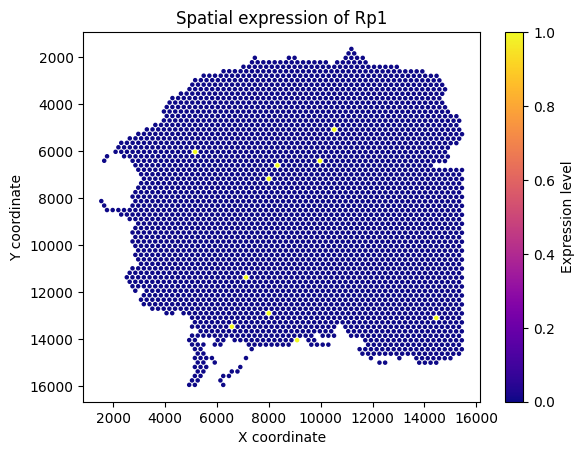

In [44]:
aligned_data = pd.merge(barcode_positions, df_precise, on="barcode")
aligned_data.drop(columns=["radius"], inplace=True)
gene_of_interest = "Rp1"

plt.scatter(
    aligned_data["x"],
    aligned_data["y"],
    c=aligned_data[gene_of_interest],
    cmap="plasma",
    s=5,
)
plt.colorbar(label="Expression level")
plt.title(f"Spatial expression of {gene_of_interest}")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.gca().invert_yaxis()
plt.show()

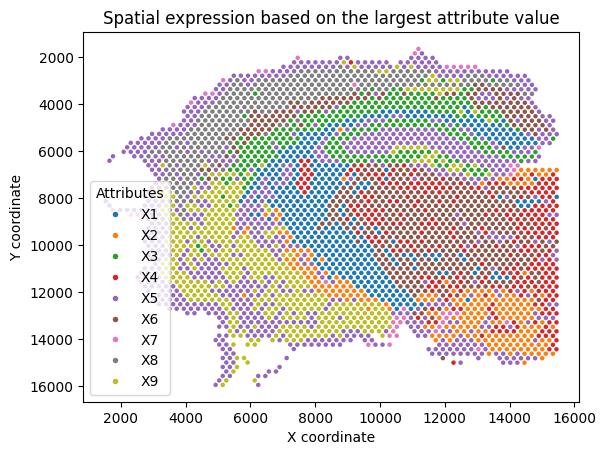

In [11]:
cluster_data_df = pd.merge(barcode_clusterMembership, barcode_positions, on="barcode")

cluster_data_df.drop(columns=["radius"], inplace=True)

# Find the attribute with the largest value for each row (X1-X9)
attribute_columns = ["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X9"]
cluster_data_df["max_attribute"] = cluster_data_df[attribute_columns].idxmax(axis=1)

# Assign a color to each attribute
attribute_colors = {
    "X1": "#1f77b4",  # blue
    "X2": "#ff7f0e",  # orange
    "X3": "#2ca02c",  # green
    "X4": "#d62728",  # red
    "X5": "#9467bd",  # purple
    "X6": "#8c564b",  # brown
    "X7": "#e377c2",  # pink
    "X8": "#7f7f7f",  # gray
    "X9": "#bcbd22",  # yellow
}

# Map colors to the max_attribute column
cluster_data_df["color"] = cluster_data_df["max_attribute"].map(attribute_colors)

# Plot
plt.scatter(cluster_data_df["x"], cluster_data_df["y"], c=cluster_data_df["color"], s=5)

# Create a legend
handles = [
    plt.Line2D(
        [0], [0], marker="o", color="w", label=attr, markersize=5, markerfacecolor=color
    )
    for attr, color in attribute_colors.items()
]
plt.legend(handles=handles, title="Attributes")

plt.title(f"Spatial expression based on the largest attribute value")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.gca().invert_yaxis()
plt.show()

In [46]:
violin_df

,barcode,Graph-based,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,Mrpl15,Lypla1,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,Vmn2r122,CAAA01147332.1
0,AAACAAGTATCTCCCA-1,Cluster 2,0.0,0.0,0.0,0.0,0.0,0.0,1.584962,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,AAACACCAATAACTGC-1,Cluster 4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,AAACAGAGCGACTCCT-1,Cluster 6,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.584962,0.0,0.0,0.0
3,AAACAGGGTCTATATT-1,Cluster 5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,AAACATTTCCCGGATT-1,Cluster 2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494,TTGTTGTGTGTCAAGA-1,Cluster 5,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
3495,TTGTTTCACATCCAGG-1,Cluster 1,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
3496,TTGTTTCATTAGTCTA-1,Cluster 3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3497,TTGTTTCCATACAACT-1,Cluster 7,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0


             min  median      mean       max  <lambda_0>
Graph-based                                             
Cluster 1    0.0     0.0  0.385723  3.321928         1.0
Cluster 2    0.0     0.0  0.262818  2.321928         0.0
Cluster 3    0.0     0.0  0.167186  4.000000         0.0
Cluster 4    0.0     0.0  0.250547  1.584962         0.0
Cluster 5    0.0     0.0  0.442925  2.584963         1.0
Cluster 6    0.0     0.0  0.179719  2.000000         0.0
Cluster 7    0.0     0.0  0.362435  2.000000         1.0
Cluster 8    0.0     0.0  0.292065  2.000000         1.0
Cluster 9    0.0     0.0  0.245908  1.584962         0.0


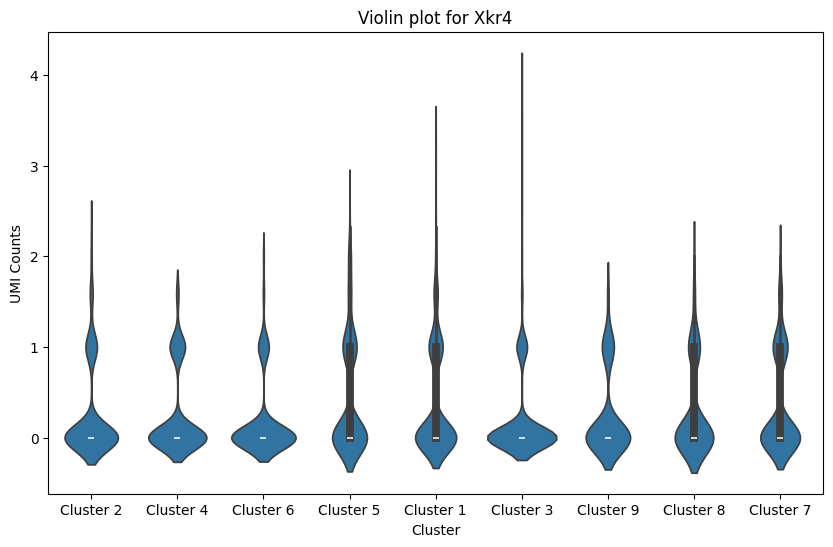

In [ ]:
gene_name = "Xkr4"
data_to_plot = violin_df[["Graph-based", gene_name]]

# Calculating descriptive statistics for each cluster
cluster_stats = (
    data_to_plot.groupby("Graph-based")[gene_name]
    .agg(["min", "median", "mean", "max", lambda x: x.quantile(0.75)])
    .rename(columns={"<lambda>": "Q3"})
)
print(cluster_stats)

plt.figure(figsize=(10, 6))
sns.violinplot(x="Graph-based", y=gene_name, data=data_to_plot)
plt.title(f"Violin plot for {gene_name}")
plt.xlabel("Cluster")
plt.ylabel("UMI Counts")
plt.show()

             min  median      mean       max  <lambda_0>
Graph-based                                             
Cluster 1    0.0     0.0  0.180297  2.137424    0.368602
Cluster 2    0.0     0.0  0.205214  2.159042    0.000000
Cluster 3    0.0     0.0  0.178306  3.665382    0.000000
Cluster 4    0.0     0.0  0.141771  1.231567    0.000000
Cluster 5    0.0     0.0  0.342200  1.755083    0.738038
Cluster 6    0.0     0.0  0.117023  1.546797    0.000000
Cluster 7    0.0     0.0  0.155643  0.905742    0.378323
Cluster 8    0.0     0.0  0.090150  0.676855    0.182145
Cluster 9    0.0     0.0  0.170340  1.104244    0.000000


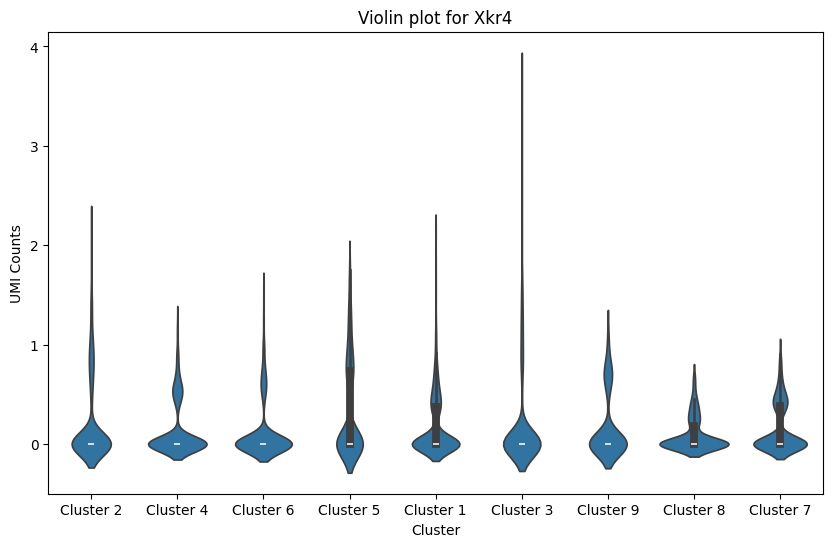

In [ ]:
gene_name = "Xkr4"
data_to_plot = violin_logNorm_df[["Graph-based", gene_name]]

# Calculating descriptive statistics for each cluster
cluster_stats = (
    data_to_plot.groupby("Graph-based")[gene_name]
    .agg(["min", "median", "mean", "max", lambda x: x.quantile(0.75)])
    .rename(columns={"<lambda>": "Q3"})
)
print(cluster_stats)

plt.figure(figsize=(10, 6))
sns.violinplot(x="Graph-based", y=gene_name, data=data_to_plot)
plt.title(f"Violin plot for {gene_name}")
plt.xlabel("Cluster")
plt.ylabel("UMI Counts")
plt.show()